# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [1]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch.optim as optim
import matplotlib.pyplot as plt

plt_interval = 50

transform = transforms.Compose(
   [transforms.ToTensor()])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# classes = ('cat', 'dog', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
label1 = 1; label2 = 7 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal flip and shuffle new array
permutation = np.random.permutation(len(trainset.train_labels))
trainset.train_data = np.concatenate([trainset.train_data, 
                                      np.flip(trainset.train_data[permutation], axis=2).copy()], 0)
trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# Grayscale and vectorize images
trainset.train_data = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in trainset.train_data])
testset.test_data = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in testset.test_data])
print("Dimensions of grayscaled vectorized images:", np.shape(trainset.train_data))

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Files already downloaded and verified
Dimensions of grayscaled vectorized images: (20000, 32, 32)
Data loaded:
- Training set size: 20000
- Test set size: 2000


Test Images:


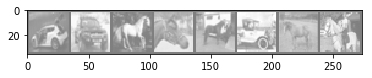

truck truck   car   car   car truck   car   car
Train Images:


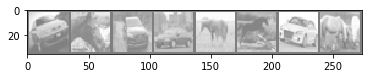

truck   car truck truck   car   car truck   car


In [2]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Weak Learner: Perceptron

In [3]:
# set learning rate
eta = 1

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    return weak_learners
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [4]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time), weak_learner

# Online BBM 

In [21]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    gamma = 0.35
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability  
            prob = 0 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
#                 print("updating", j, "data", t)
#                 predict = predict_WL(weak_learners, x, j-1)
#                 if (predict*y) < 0:
#                     weak_learners[j-1] = weak_learners[j-1] + eta * x * y
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
                
    return n_mistakes_over_time, weak_learners

# AdaBoost OL

In [6]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [7]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        for data in testloader:
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL(weak_learners, x, i)
            correct += (prediction == y).sum()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    for data in testloader: 
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg1(weak_learners, x)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    for data in testloader:
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [10]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(architecture, T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    weak_learner = np.zeros(1024)
    mistakes, weak_learner = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, architecture):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(1024)) 
    
    # test
    mistakes, weak_learners = onlineBBM(weak_learners, T)
    print(weak_learners)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, architecture):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(1024)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Fraction of mistakes after 10000 iterations: 0.3251
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 72 %


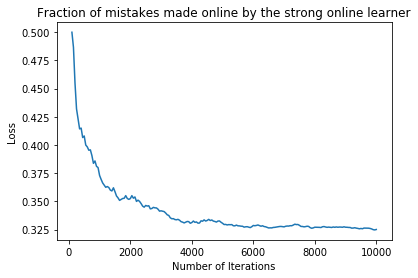

In [11]:
evaluate_baseline(architecture=0, T=10000)

## Online BBM

Evaluating Online BBM:

updating 1 data 1
updating 2 data 1
updating 3 data 1
updating 1 data 2
updating 2 data 2
updating 3 data 2
updating 1 data 3
updating 2 data 3
updating 3 data 3
updating 1 data 4
updating 2 data 4
updating 3 data 4
updating 1 data 5
updating 2 data 5
updating 3 data 5
updating 1 data 6
updating 2 data 6
updating 3 data 6
updating 1 data 7
updating 2 data 7
updating 3 data 7
updating 1 data 8
updating 2 data 8
updating 1 data 9
updating 2 data 9
updating 1 data 10
updating 2 data 10
updating 3 data 10
updating 1 data 11
updating 2 data 11
updating 3 data 11
updating 1 data 12
updating 2 data 12
updating 1 data 13
updating 2 data 13
updating 3 data 13
updating 1 data 14
updating 2 data 14
updating 1 data 15
updating 2 data 15
updating 1 data 16
updating 2 data 16
updating 3 data 16
updating 1 data 17
updating 2 data 17
updating 3 data 17
updating 1 data 18
updating 2 data 18
updating 3 data 18
updating 1 data 19
updating 2 data 19
updating 3 data 19
updating 1 da

updating 1 data 263
updating 1 data 264
updating 1 data 265
updating 2 data 265
updating 1 data 266
updating 2 data 266
updating 3 data 266
updating 1 data 267
updating 2 data 267
updating 3 data 267
updating 1 data 268
updating 2 data 268
updating 1 data 269
updating 2 data 269
updating 3 data 269
updating 1 data 270
updating 3 data 270
updating 1 data 271
updating 3 data 271
updating 1 data 272
updating 2 data 272
updating 3 data 272
updating 1 data 273
updating 2 data 273
updating 3 data 273
updating 1 data 274
updating 2 data 274
updating 3 data 274
updating 1 data 275
updating 2 data 275
updating 3 data 275
updating 1 data 276
updating 2 data 276
updating 3 data 276
updating 1 data 277
updating 2 data 277
updating 3 data 277
updating 1 data 278
updating 1 data 279
updating 2 data 279
updating 1 data 280
updating 2 data 280
updating 1 data 281
updating 2 data 281
updating 1 data 282
updating 2 data 282
updating 3 data 282
updating 1 data 283
updating 2 data 283
updating 3 data 283


updating 1 data 460
updating 2 data 460
updating 3 data 460
updating 1 data 461
updating 2 data 461
updating 3 data 461
updating 1 data 462
updating 1 data 463
updating 2 data 463
updating 3 data 463
updating 1 data 464
updating 2 data 464
updating 1 data 465
updating 1 data 466
updating 2 data 466
updating 3 data 466
updating 1 data 467
updating 2 data 467
updating 3 data 467
updating 1 data 468
updating 1 data 469
updating 2 data 469
updating 1 data 470
updating 2 data 470
updating 3 data 470
updating 1 data 471
updating 2 data 471
updating 3 data 471
updating 1 data 472
updating 2 data 472
updating 3 data 472
updating 1 data 473
updating 2 data 473
updating 1 data 474
updating 2 data 474
updating 3 data 474
updating 1 data 475
updating 2 data 475
updating 1 data 476
updating 1 data 477
updating 3 data 477
updating 1 data 478
updating 2 data 478
updating 3 data 478
updating 1 data 479
updating 1 data 480
updating 2 data 480
updating 3 data 480
updating 1 data 481
updating 2 data 481


updating 1 data 730
updating 1 data 731
updating 2 data 731
updating 1 data 732
updating 2 data 732
updating 1 data 733
updating 2 data 733
updating 3 data 733
updating 1 data 734
updating 3 data 734
updating 1 data 735
updating 2 data 735
updating 1 data 736
updating 1 data 737
updating 2 data 737
updating 3 data 737
updating 1 data 738
updating 2 data 738
updating 1 data 739
updating 1 data 740
updating 1 data 741
updating 2 data 741
updating 3 data 741
updating 1 data 742
updating 2 data 742
updating 3 data 742
updating 1 data 743
updating 2 data 743
updating 1 data 744
updating 2 data 744
updating 3 data 744
updating 1 data 745
updating 1 data 746
updating 1 data 747
updating 2 data 747
updating 1 data 748
updating 2 data 748
updating 1 data 749
updating 2 data 749
updating 1 data 750
updating 2 data 750
updating 3 data 750
updating 1 data 751
updating 1 data 752
updating 2 data 752
updating 3 data 752
updating 1 data 753
updating 2 data 753
updating 3 data 753
updating 1 data 754


updating 1 data 927
updating 2 data 927
updating 3 data 927
updating 1 data 928
updating 2 data 928
updating 3 data 928
updating 1 data 929
updating 3 data 929
updating 1 data 930
updating 2 data 930
updating 3 data 930
updating 1 data 931
updating 2 data 931
updating 3 data 931
updating 1 data 932
updating 2 data 932
updating 3 data 932
updating 1 data 933
updating 2 data 933
updating 1 data 934
updating 2 data 934
updating 3 data 934
updating 1 data 935
updating 2 data 935
updating 3 data 935
updating 1 data 936
updating 2 data 936
updating 3 data 936
updating 1 data 937
updating 2 data 937
updating 3 data 937
updating 1 data 938
updating 2 data 938
updating 1 data 939
updating 2 data 939
updating 3 data 939
updating 1 data 940
updating 1 data 941
updating 3 data 941
updating 1 data 942
updating 2 data 942
updating 3 data 942
updating 1 data 943
updating 1 data 944
updating 2 data 944
updating 3 data 944
updating 1 data 945
updating 2 data 945
updating 1 data 946
updating 2 data 946


updating 1 data 1116
updating 2 data 1116
updating 3 data 1116
updating 1 data 1117
updating 1 data 1118
updating 1 data 1119
updating 2 data 1119
updating 1 data 1120
updating 3 data 1120
updating 1 data 1121
updating 2 data 1121
updating 3 data 1121
updating 1 data 1122
updating 1 data 1123
updating 2 data 1123
updating 3 data 1123
updating 1 data 1124
updating 2 data 1124
updating 3 data 1124
updating 1 data 1125
updating 3 data 1125
updating 1 data 1126
updating 2 data 1126
updating 3 data 1126
updating 1 data 1127
updating 2 data 1127
updating 1 data 1128
updating 2 data 1128
updating 3 data 1128
updating 1 data 1129
updating 1 data 1130
updating 1 data 1131
updating 2 data 1131
updating 3 data 1131
updating 1 data 1132
updating 2 data 1132
updating 3 data 1132
updating 1 data 1133
updating 3 data 1133
updating 1 data 1134
updating 2 data 1134
updating 3 data 1134
updating 1 data 1135
updating 1 data 1136
updating 2 data 1136
updating 1 data 1137
updating 2 data 1137
updating 3 da

updating 1 data 1306
updating 1 data 1307
updating 1 data 1308
updating 2 data 1308
updating 1 data 1309
updating 1 data 1310
updating 1 data 1311
updating 2 data 1311
updating 3 data 1311
updating 1 data 1312
updating 3 data 1312
updating 1 data 1313
updating 3 data 1313
updating 1 data 1314
updating 2 data 1314
updating 3 data 1314
updating 1 data 1315
updating 3 data 1315
updating 1 data 1316
updating 1 data 1317
updating 2 data 1317
updating 3 data 1317
updating 1 data 1318
updating 2 data 1318
updating 3 data 1318
updating 1 data 1319
updating 1 data 1320
updating 3 data 1320
updating 1 data 1321
updating 2 data 1321
updating 3 data 1321
updating 1 data 1322
updating 2 data 1322
updating 3 data 1322
updating 1 data 1323
updating 1 data 1324
updating 1 data 1325
updating 1 data 1326
updating 1 data 1327
updating 2 data 1327
updating 3 data 1327
updating 1 data 1328
updating 1 data 1329
updating 2 data 1329
updating 3 data 1329
updating 1 data 1330
updating 2 data 1330
updating 3 da

updating 1 data 1575
updating 2 data 1575
updating 3 data 1575
updating 1 data 1576
updating 2 data 1576
updating 1 data 1577
updating 2 data 1577
updating 3 data 1577
updating 1 data 1578
updating 2 data 1578
updating 3 data 1578
updating 1 data 1579
updating 2 data 1579
updating 1 data 1580
updating 3 data 1580
updating 1 data 1581
updating 1 data 1582
updating 2 data 1582
updating 3 data 1582
updating 1 data 1583
updating 1 data 1584
updating 2 data 1584
updating 3 data 1584
updating 1 data 1585
updating 2 data 1585
updating 1 data 1586
updating 1 data 1587
updating 2 data 1587
updating 1 data 1588
updating 1 data 1589
updating 2 data 1589
updating 1 data 1590
updating 2 data 1590
updating 1 data 1591
updating 2 data 1591
updating 1 data 1592
updating 1 data 1593
updating 1 data 1594
updating 1 data 1595
updating 2 data 1595
updating 1 data 1596
updating 2 data 1596
updating 3 data 1596
updating 1 data 1597
updating 1 data 1598
updating 2 data 1598
updating 3 data 1598
updating 1 da

updating 1 data 1753
updating 3 data 1753
updating 1 data 1754
updating 2 data 1754
updating 3 data 1754
updating 1 data 1755
updating 3 data 1755
updating 1 data 1756
updating 1 data 1757
updating 2 data 1757
updating 1 data 1758
updating 1 data 1759
updating 1 data 1760
updating 2 data 1760
updating 3 data 1760
updating 1 data 1761
updating 2 data 1761
updating 3 data 1761
updating 1 data 1762
updating 2 data 1762
updating 3 data 1762
updating 1 data 1763
updating 2 data 1763
updating 3 data 1763
updating 1 data 1764
updating 3 data 1764
updating 1 data 1765
updating 2 data 1765
updating 3 data 1765
updating 1 data 1766
updating 2 data 1766
updating 3 data 1766
updating 1 data 1767
updating 2 data 1767
updating 3 data 1767
updating 1 data 1768
updating 2 data 1768
updating 3 data 1768
updating 1 data 1769
updating 2 data 1769
updating 1 data 1770
updating 1 data 1771
updating 3 data 1771
updating 1 data 1772
updating 2 data 1772
updating 1 data 1773
updating 3 data 1773
updating 1 da

updating 1 data 1928
updating 1 data 1929
updating 2 data 1929
updating 3 data 1929
updating 1 data 1930
updating 2 data 1930
updating 3 data 1930
updating 1 data 1931
updating 2 data 1931
updating 3 data 1931
updating 1 data 1932
updating 2 data 1932
updating 3 data 1932
updating 1 data 1933
updating 3 data 1933
updating 1 data 1934
updating 2 data 1934
updating 3 data 1934
updating 1 data 1935
updating 2 data 1935
updating 3 data 1935
updating 1 data 1936
updating 2 data 1936
updating 1 data 1937
updating 1 data 1938
updating 2 data 1938
updating 3 data 1938
updating 1 data 1939
updating 1 data 1940
updating 1 data 1941
updating 2 data 1941
updating 1 data 1942
updating 2 data 1942
updating 1 data 1943
updating 2 data 1943
updating 3 data 1943
updating 1 data 1944
updating 2 data 1944
updating 3 data 1944
updating 1 data 1945
updating 2 data 1945
updating 3 data 1945
updating 1 data 1946
updating 1 data 1947
updating 1 data 1948
updating 1 data 1949
updating 1 data 1950
updating 2 da

updating 1 data 2106
updating 2 data 2106
updating 3 data 2106
updating 1 data 2107
updating 3 data 2107
updating 1 data 2108
updating 2 data 2108
updating 1 data 2109
updating 2 data 2109
updating 3 data 2109
updating 1 data 2110
updating 2 data 2110
updating 1 data 2111
updating 2 data 2111
updating 3 data 2111
updating 1 data 2112
updating 1 data 2113
updating 2 data 2113
updating 1 data 2114
updating 2 data 2114
updating 3 data 2114
updating 1 data 2115
updating 2 data 2115
updating 1 data 2116
updating 1 data 2117
updating 1 data 2118
updating 2 data 2118
updating 1 data 2119
updating 1 data 2120
updating 2 data 2120
updating 3 data 2120
updating 1 data 2121
updating 2 data 2121
updating 3 data 2121
updating 1 data 2122
updating 2 data 2122
updating 1 data 2123
updating 2 data 2123
updating 3 data 2123
updating 1 data 2124
updating 2 data 2124
updating 3 data 2124
updating 1 data 2125
updating 2 data 2125
updating 3 data 2125
updating 1 data 2126
updating 2 data 2126
updating 3 da

updating 1 data 2297
updating 2 data 2297
updating 3 data 2297
updating 1 data 2298
updating 2 data 2298
updating 3 data 2298
updating 1 data 2299
updating 2 data 2299
updating 1 data 2300
updating 2 data 2300
updating 1 data 2301
updating 2 data 2301
updating 3 data 2301
updating 1 data 2302
updating 2 data 2302
updating 1 data 2303
updating 2 data 2303
updating 1 data 2304
updating 2 data 2304
updating 3 data 2304
updating 1 data 2305
updating 2 data 2305
updating 3 data 2305
updating 1 data 2306
updating 2 data 2306
updating 3 data 2306
updating 1 data 2307
updating 3 data 2307
updating 1 data 2308
updating 1 data 2309
updating 1 data 2310
updating 2 data 2310
updating 3 data 2310
updating 1 data 2311
updating 3 data 2311
updating 1 data 2312
updating 2 data 2312
updating 1 data 2313
updating 2 data 2313
updating 3 data 2313
updating 1 data 2314
updating 2 data 2314
updating 3 data 2314
updating 1 data 2315
updating 2 data 2315
updating 3 data 2315
updating 1 data 2316
updating 2 da

updating 1 data 2557
updating 1 data 2558
updating 1 data 2559
updating 1 data 2560
updating 2 data 2560
updating 3 data 2560
updating 1 data 2561
updating 2 data 2561
updating 1 data 2562
updating 2 data 2562
updating 3 data 2562
updating 1 data 2563
updating 2 data 2563
updating 1 data 2564
updating 3 data 2564
updating 1 data 2565
updating 2 data 2565
updating 3 data 2565
updating 1 data 2566
updating 3 data 2566
updating 1 data 2567
updating 2 data 2567
updating 3 data 2567
updating 1 data 2568
updating 2 data 2568
updating 1 data 2569
updating 1 data 2570
updating 2 data 2570
updating 3 data 2570
updating 1 data 2571
updating 2 data 2571
updating 1 data 2572
updating 1 data 2573
updating 2 data 2573
updating 3 data 2573
updating 1 data 2574
updating 2 data 2574
updating 3 data 2574
updating 1 data 2575
updating 2 data 2575
updating 1 data 2576
updating 2 data 2576
updating 3 data 2576
updating 1 data 2577
updating 2 data 2577
updating 1 data 2578
updating 2 data 2578
updating 3 da

updating 1 data 2740
updating 2 data 2740
updating 3 data 2740
updating 1 data 2741
updating 1 data 2742
updating 2 data 2742
updating 3 data 2742
updating 1 data 2743
updating 2 data 2743
updating 3 data 2743
updating 1 data 2744
updating 2 data 2744
updating 3 data 2744
updating 1 data 2745
updating 2 data 2745
updating 1 data 2746
updating 1 data 2747
updating 2 data 2747
updating 3 data 2747
updating 1 data 2748
updating 2 data 2748
updating 1 data 2749
updating 2 data 2749
updating 3 data 2749
updating 1 data 2750
updating 2 data 2750
updating 3 data 2750
updating 1 data 2751
updating 1 data 2752
updating 1 data 2753
updating 2 data 2753
updating 3 data 2753
updating 1 data 2754
updating 2 data 2754
updating 1 data 2755
updating 2 data 2755
updating 1 data 2756
updating 2 data 2756
updating 3 data 2756
updating 1 data 2757
updating 2 data 2757
updating 3 data 2757
updating 1 data 2758
updating 2 data 2758
updating 3 data 2758
updating 1 data 2759
updating 2 data 2759
updating 3 da

updating 1 data 2923
updating 2 data 2923
updating 1 data 2924
updating 3 data 2924
updating 1 data 2925
updating 2 data 2925
updating 1 data 2926
updating 1 data 2927
updating 1 data 2928
updating 2 data 2928
updating 1 data 2929
updating 2 data 2929
updating 1 data 2930
updating 2 data 2930
updating 3 data 2930
updating 1 data 2931
updating 1 data 2932
updating 2 data 2932
updating 1 data 2933
updating 1 data 2934
updating 2 data 2934
updating 3 data 2934
updating 1 data 2935
updating 2 data 2935
updating 1 data 2936
updating 1 data 2937
updating 2 data 2937
updating 3 data 2937
updating 1 data 2938
updating 2 data 2938
updating 1 data 2939
updating 2 data 2939
updating 1 data 2940
updating 2 data 2940
updating 3 data 2940
updating 1 data 2941
updating 2 data 2941
updating 3 data 2941
updating 1 data 2942
updating 2 data 2942
updating 1 data 2943
updating 1 data 2944
updating 2 data 2944
updating 3 data 2944
updating 1 data 2945
updating 1 data 2946
updating 2 data 2946
updating 1 da

updating 1 data 3110
updating 2 data 3110
updating 3 data 3110
updating 1 data 3111
updating 2 data 3111
updating 1 data 3112
updating 2 data 3112
updating 3 data 3112
updating 1 data 3113
updating 2 data 3113
updating 3 data 3113
updating 1 data 3114
updating 2 data 3114
updating 3 data 3114
updating 1 data 3115
updating 2 data 3115
updating 1 data 3116
updating 2 data 3116
updating 3 data 3116
updating 1 data 3117
updating 2 data 3117
updating 1 data 3118
updating 2 data 3118
updating 3 data 3118
updating 1 data 3119
updating 1 data 3120
updating 1 data 3121
updating 2 data 3121
updating 1 data 3122
updating 3 data 3122
updating 1 data 3123
updating 1 data 3124
updating 2 data 3124
updating 3 data 3124
updating 1 data 3125
updating 2 data 3125
updating 3 data 3125
updating 1 data 3126
updating 2 data 3126
updating 1 data 3127
updating 2 data 3127
updating 1 data 3128
updating 2 data 3128
updating 1 data 3129
updating 1 data 3130
updating 2 data 3130
updating 1 data 3131
updating 2 da

updating 1 data 3296
updating 2 data 3296
updating 1 data 3297
updating 3 data 3297
updating 1 data 3298
updating 2 data 3298
updating 1 data 3299
updating 2 data 3299
updating 1 data 3300
updating 2 data 3300
updating 3 data 3300
updating 1 data 3301
updating 1 data 3302
updating 2 data 3302
updating 3 data 3302
updating 1 data 3303
updating 2 data 3303
updating 3 data 3303
updating 1 data 3304
updating 2 data 3304
updating 3 data 3304
updating 1 data 3305
updating 2 data 3305
updating 3 data 3305
updating 1 data 3306
updating 2 data 3306
updating 3 data 3306
updating 1 data 3307
updating 3 data 3307
updating 1 data 3308
updating 2 data 3308
updating 3 data 3308
updating 1 data 3309
updating 1 data 3310
updating 2 data 3310
updating 3 data 3310
updating 1 data 3311
updating 2 data 3311
updating 1 data 3312
updating 2 data 3312
updating 3 data 3312
updating 1 data 3313
updating 2 data 3313
updating 3 data 3313
updating 1 data 3314
updating 2 data 3314
updating 3 data 3314
updating 1 da

updating 2 data 3469
updating 3 data 3469
updating 1 data 3470
updating 1 data 3471
updating 2 data 3471
updating 3 data 3471
updating 1 data 3472
updating 1 data 3473
updating 3 data 3473
updating 1 data 3474
updating 1 data 3475
updating 2 data 3475
updating 1 data 3476
updating 1 data 3477
updating 2 data 3477
updating 1 data 3478
updating 2 data 3478
updating 1 data 3479
updating 1 data 3480
updating 2 data 3480
updating 1 data 3481
updating 2 data 3481
updating 3 data 3481
updating 1 data 3482
updating 3 data 3482
updating 1 data 3483
updating 2 data 3483
updating 1 data 3484
updating 1 data 3485
updating 2 data 3485
updating 3 data 3485
updating 1 data 3486
updating 1 data 3487
updating 3 data 3487
updating 1 data 3488
updating 2 data 3488
updating 3 data 3488
updating 1 data 3489
updating 2 data 3489
updating 3 data 3489
updating 1 data 3490
updating 2 data 3490
updating 3 data 3490
updating 1 data 3491
updating 2 data 3491
updating 3 data 3491
updating 1 data 3492
updating 2 da

updating 1 data 3722
updating 1 data 3723
updating 2 data 3723
updating 3 data 3723
updating 1 data 3724
updating 2 data 3724
updating 1 data 3725
updating 2 data 3725
updating 3 data 3725
updating 1 data 3726
updating 2 data 3726
updating 1 data 3727
updating 2 data 3727
updating 1 data 3728
updating 2 data 3728
updating 3 data 3728
updating 1 data 3729
updating 2 data 3729
updating 3 data 3729
updating 1 data 3730
updating 2 data 3730
updating 3 data 3730
updating 1 data 3731
updating 2 data 3731
updating 3 data 3731
updating 1 data 3732
updating 1 data 3733
updating 1 data 3734
updating 1 data 3735
updating 1 data 3736
updating 1 data 3737
updating 2 data 3737
updating 3 data 3737
updating 1 data 3738
updating 1 data 3739
updating 2 data 3739
updating 3 data 3739
updating 1 data 3740
updating 2 data 3740
updating 1 data 3741
updating 2 data 3741
updating 3 data 3741
updating 1 data 3742
updating 2 data 3742
updating 1 data 3743
updating 2 data 3743
updating 3 data 3743
updating 1 da

updating 3 data 3897
updating 1 data 3898
updating 2 data 3898
updating 3 data 3898
updating 1 data 3899
updating 2 data 3899
updating 3 data 3899
updating 1 data 3900
updating 2 data 3900
updating 3 data 3900
updating 1 data 3901
updating 2 data 3901
updating 1 data 3902
updating 2 data 3902
updating 1 data 3903
updating 2 data 3903
updating 3 data 3903
updating 1 data 3904
updating 1 data 3905
updating 2 data 3905
updating 3 data 3905
updating 1 data 3906
updating 2 data 3906
updating 3 data 3906
updating 1 data 3907
updating 1 data 3908
updating 1 data 3909
updating 2 data 3909
updating 1 data 3910
updating 2 data 3910
updating 1 data 3911
updating 2 data 3911
updating 3 data 3911
updating 1 data 3912
updating 3 data 3912
updating 1 data 3913
updating 2 data 3913
updating 1 data 3914
updating 1 data 3915
updating 2 data 3915
updating 3 data 3915
updating 1 data 3916
updating 2 data 3916
updating 1 data 3917
updating 2 data 3917
updating 3 data 3917
updating 1 data 3918
updating 2 da

updating 1 data 4083
updating 2 data 4083
updating 3 data 4083
updating 1 data 4084
updating 1 data 4085
updating 2 data 4085
updating 3 data 4085
updating 1 data 4086
updating 2 data 4086
updating 1 data 4087
updating 2 data 4087
updating 3 data 4087
updating 1 data 4088
updating 1 data 4089
updating 2 data 4089
updating 1 data 4090
updating 3 data 4090
updating 1 data 4091
updating 2 data 4091
updating 1 data 4092
updating 2 data 4092
updating 1 data 4093
updating 1 data 4094
updating 3 data 4094
updating 1 data 4095
updating 1 data 4096
updating 2 data 4096
updating 1 data 4097
updating 2 data 4097
updating 3 data 4097
updating 1 data 4098
updating 1 data 4099
updating 2 data 4099
updating 3 data 4099
updating 1 data 4100
updating 2 data 4100
updating 1 data 4101
updating 1 data 4102
updating 2 data 4102
updating 3 data 4102
updating 1 data 4103
updating 2 data 4103
updating 1 data 4104
updating 2 data 4104
updating 3 data 4104
updating 1 data 4105
updating 2 data 4105
updating 3 da

updating 1 data 4268
updating 1 data 4269
updating 2 data 4269
updating 3 data 4269
updating 1 data 4270
updating 1 data 4271
updating 1 data 4272
updating 2 data 4272
updating 3 data 4272
updating 1 data 4273
updating 1 data 4274
updating 1 data 4275
updating 1 data 4276
updating 2 data 4276
updating 3 data 4276
updating 1 data 4277
updating 2 data 4277
updating 1 data 4278
updating 2 data 4278
updating 3 data 4278
updating 1 data 4279
updating 1 data 4280
updating 2 data 4280
updating 3 data 4280
updating 1 data 4281
updating 1 data 4282
updating 2 data 4282
updating 3 data 4282
updating 1 data 4283
updating 2 data 4283
updating 1 data 4284
updating 3 data 4284
updating 1 data 4285
updating 2 data 4285
updating 3 data 4285
updating 1 data 4286
updating 2 data 4286
updating 3 data 4286
updating 1 data 4287
updating 3 data 4287
updating 1 data 4288
updating 1 data 4289
updating 1 data 4290
updating 2 data 4290
updating 1 data 4291
updating 2 data 4291
updating 3 data 4291
updating 1 da

updating 1 data 4458
updating 2 data 4458
updating 3 data 4458
updating 1 data 4459
updating 2 data 4459
updating 3 data 4459
updating 1 data 4460
updating 2 data 4460
updating 3 data 4460
updating 1 data 4461
updating 2 data 4461
updating 3 data 4461
updating 1 data 4462
updating 2 data 4462
updating 3 data 4462
updating 1 data 4463
updating 1 data 4464
updating 1 data 4465
updating 2 data 4465
updating 3 data 4465
updating 1 data 4466
updating 2 data 4466
updating 1 data 4467
updating 2 data 4467
updating 3 data 4467
updating 1 data 4468
updating 1 data 4469
updating 1 data 4470
updating 1 data 4471
updating 2 data 4471
updating 3 data 4471
updating 1 data 4472
updating 2 data 4472
updating 3 data 4472
updating 1 data 4473
updating 2 data 4473
updating 1 data 4474
updating 1 data 4475
updating 1 data 4476
updating 1 data 4477
updating 3 data 4477
updating 1 data 4478
updating 2 data 4478
updating 1 data 4479
updating 1 data 4480
updating 2 data 4480
updating 1 data 4481
updating 2 da

updating 1 data 4647
updating 2 data 4647
updating 1 data 4648
updating 2 data 4648
updating 3 data 4648
updating 1 data 4649
updating 1 data 4650
updating 3 data 4650
updating 1 data 4651
updating 2 data 4651
updating 3 data 4651
updating 1 data 4652
updating 2 data 4652
updating 3 data 4652
updating 1 data 4653
updating 1 data 4654
updating 1 data 4655
updating 2 data 4655
updating 3 data 4655
updating 1 data 4656
updating 1 data 4657
updating 1 data 4658
updating 2 data 4658
updating 3 data 4658
updating 1 data 4659
updating 2 data 4659
updating 3 data 4659
updating 1 data 4660
updating 2 data 4660
updating 1 data 4661
updating 2 data 4661
updating 3 data 4661
updating 1 data 4662
updating 2 data 4662
updating 3 data 4662
updating 1 data 4663
updating 2 data 4663
updating 3 data 4663
updating 1 data 4664
updating 1 data 4665
updating 3 data 4665
updating 1 data 4666
updating 1 data 4667
updating 2 data 4667
updating 1 data 4668
updating 2 data 4668
updating 1 data 4669
updating 2 da

updating 1 data 4841
updating 2 data 4841
updating 3 data 4841
updating 1 data 4842
updating 2 data 4842
updating 1 data 4843
updating 2 data 4843
updating 3 data 4843
updating 1 data 4844
updating 2 data 4844
updating 3 data 4844
updating 1 data 4845
updating 1 data 4846
updating 2 data 4846
updating 3 data 4846
updating 1 data 4847
updating 2 data 4847
updating 3 data 4847
updating 1 data 4848
updating 2 data 4848
updating 1 data 4849
updating 2 data 4849
updating 3 data 4849
updating 1 data 4850
updating 1 data 4851
updating 2 data 4851
updating 1 data 4852
updating 2 data 4852
updating 3 data 4852
updating 1 data 4853
updating 1 data 4854
updating 2 data 4854
updating 3 data 4854
updating 1 data 4855
updating 2 data 4855
updating 1 data 4856
updating 3 data 4856
updating 1 data 4857
updating 2 data 4857
updating 3 data 4857
updating 1 data 4858
updating 2 data 4858
updating 3 data 4858
updating 1 data 4859
updating 2 data 4859
updating 3 data 4859
updating 1 data 4860
updating 2 da

updating 3 data 5025
updating 1 data 5026
updating 2 data 5026
updating 1 data 5027
updating 1 data 5028
updating 2 data 5028
updating 3 data 5028
updating 1 data 5029
updating 1 data 5030
updating 1 data 5031
updating 3 data 5031
updating 1 data 5032
updating 3 data 5032
updating 1 data 5033
updating 1 data 5034
updating 2 data 5034
updating 3 data 5034
updating 1 data 5035
updating 2 data 5035
updating 1 data 5036
updating 2 data 5036
updating 1 data 5037
updating 2 data 5037
updating 1 data 5038
updating 1 data 5039
updating 2 data 5039
updating 1 data 5040
updating 1 data 5041
updating 1 data 5042
updating 2 data 5042
updating 3 data 5042
updating 1 data 5043
updating 2 data 5043
updating 3 data 5043
updating 1 data 5044
updating 2 data 5044
updating 3 data 5044
updating 1 data 5045
updating 2 data 5045
updating 3 data 5045
updating 1 data 5046
updating 3 data 5046
updating 1 data 5047
updating 2 data 5047
updating 3 data 5047
updating 1 data 5048
updating 2 data 5048
updating 1 da

updating 1 data 5217
updating 3 data 5217
updating 1 data 5218
updating 2 data 5218
updating 1 data 5219
updating 3 data 5219
updating 1 data 5220
updating 2 data 5220
updating 1 data 5221
updating 2 data 5221
updating 3 data 5221
updating 1 data 5222
updating 1 data 5223
updating 1 data 5224
updating 2 data 5224
updating 1 data 5225
updating 2 data 5225
updating 3 data 5225
updating 1 data 5226
updating 2 data 5226
updating 3 data 5226
updating 1 data 5227
updating 3 data 5227
updating 1 data 5228
updating 2 data 5228
updating 1 data 5229
updating 2 data 5229
updating 3 data 5229
updating 1 data 5230
updating 1 data 5231
updating 1 data 5232
updating 2 data 5232
updating 1 data 5233
updating 2 data 5233
updating 3 data 5233
updating 1 data 5234
updating 2 data 5234
updating 3 data 5234
updating 1 data 5235
updating 1 data 5236
updating 2 data 5236
updating 3 data 5236
updating 1 data 5237
updating 2 data 5237
updating 1 data 5238
updating 3 data 5238
updating 1 data 5239
updating 1 da

updating 1 data 5412
updating 2 data 5412
updating 3 data 5412
updating 1 data 5413
updating 2 data 5413
updating 3 data 5413
updating 1 data 5414
updating 1 data 5415
updating 2 data 5415
updating 3 data 5415
updating 1 data 5416
updating 2 data 5416
updating 1 data 5417
updating 2 data 5417
updating 3 data 5417
updating 1 data 5418
updating 2 data 5418
updating 1 data 5419
updating 1 data 5420
updating 1 data 5421
updating 2 data 5421
updating 1 data 5422
updating 3 data 5422
updating 1 data 5423
updating 2 data 5423
updating 1 data 5424
updating 2 data 5424
updating 3 data 5424
updating 1 data 5425
updating 2 data 5425
updating 3 data 5425
updating 1 data 5426
updating 1 data 5427
updating 2 data 5427
updating 3 data 5427
updating 1 data 5428
updating 3 data 5428
updating 1 data 5429
updating 2 data 5429
updating 1 data 5430
updating 2 data 5430
updating 3 data 5430
updating 1 data 5431
updating 2 data 5431
updating 3 data 5431
updating 1 data 5432
updating 2 data 5432
updating 1 da

updating 3 data 5690
updating 1 data 5691
updating 3 data 5691
updating 1 data 5692
updating 2 data 5692
updating 1 data 5693
updating 2 data 5693
updating 3 data 5693
updating 1 data 5694
updating 2 data 5694
updating 1 data 5695
updating 2 data 5695
updating 3 data 5695
updating 1 data 5696
updating 2 data 5696
updating 1 data 5697
updating 2 data 5697
updating 3 data 5697
updating 1 data 5698
updating 1 data 5699
updating 2 data 5699
updating 1 data 5700
updating 2 data 5700
updating 1 data 5701
updating 3 data 5701
updating 1 data 5702
updating 2 data 5702
updating 3 data 5702
updating 1 data 5703
updating 2 data 5703
updating 3 data 5703
updating 1 data 5704
updating 2 data 5704
updating 3 data 5704
updating 1 data 5705
updating 2 data 5705
updating 3 data 5705
updating 1 data 5706
updating 1 data 5707
updating 2 data 5707
updating 1 data 5708
updating 2 data 5708
updating 1 data 5709
updating 1 data 5710
updating 2 data 5710
updating 3 data 5710
updating 1 data 5711
updating 1 da

updating 1 data 5889
updating 2 data 5889
updating 1 data 5890
updating 2 data 5890
updating 1 data 5891
updating 2 data 5891
updating 3 data 5891
updating 1 data 5892
updating 1 data 5893
updating 2 data 5893
updating 3 data 5893
updating 1 data 5894
updating 2 data 5894
updating 3 data 5894
updating 1 data 5895
updating 2 data 5895
updating 3 data 5895
updating 1 data 5896
updating 3 data 5896
updating 1 data 5897
updating 2 data 5897
updating 1 data 5898
updating 1 data 5899
updating 1 data 5900
updating 2 data 5900
updating 1 data 5901
updating 2 data 5901
updating 3 data 5901
updating 1 data 5902
updating 2 data 5902
updating 3 data 5902
updating 1 data 5903
updating 2 data 5903
updating 3 data 5903
updating 1 data 5904
updating 1 data 5905
updating 2 data 5905
updating 1 data 5906
updating 2 data 5906
updating 3 data 5906
updating 1 data 5907
updating 2 data 5907
updating 3 data 5907
updating 1 data 5908
updating 1 data 5909
updating 2 data 5909
updating 3 data 5909
updating 1 da

updating 1 data 6084
updating 2 data 6084
updating 1 data 6085
updating 2 data 6085
updating 3 data 6085
updating 1 data 6086
updating 1 data 6087
updating 2 data 6087
updating 3 data 6087
updating 1 data 6088
updating 2 data 6088
updating 1 data 6089
updating 3 data 6089
updating 1 data 6090
updating 2 data 6090
updating 3 data 6090
updating 1 data 6091
updating 2 data 6091
updating 3 data 6091
updating 1 data 6092
updating 2 data 6092
updating 3 data 6092
updating 1 data 6093
updating 2 data 6093
updating 1 data 6094
updating 2 data 6094
updating 3 data 6094
updating 1 data 6095
updating 2 data 6095
updating 3 data 6095
updating 1 data 6096
updating 2 data 6096
updating 3 data 6096
updating 1 data 6097
updating 1 data 6098
updating 2 data 6098
updating 1 data 6099
updating 2 data 6099
updating 1 data 6100
updating 1 data 6101
updating 2 data 6101
updating 3 data 6101
updating 1 data 6102
updating 2 data 6102
updating 1 data 6103
updating 2 data 6103
updating 3 data 6103
updating 1 da

updating 1 data 6270
updating 2 data 6270
updating 3 data 6270
updating 1 data 6271
updating 1 data 6272
updating 2 data 6272
updating 1 data 6273
updating 2 data 6273
updating 1 data 6274
updating 3 data 6274
updating 1 data 6275
updating 2 data 6275
updating 1 data 6276
updating 2 data 6276
updating 1 data 6277
updating 3 data 6277
updating 1 data 6278
updating 1 data 6279
updating 2 data 6279
updating 1 data 6280
updating 1 data 6281
updating 2 data 6281
updating 3 data 6281
updating 1 data 6282
updating 2 data 6282
updating 3 data 6282
updating 1 data 6283
updating 3 data 6283
updating 1 data 6284
updating 1 data 6285
updating 2 data 6285
updating 1 data 6286
updating 1 data 6287
updating 2 data 6287
updating 1 data 6288
updating 1 data 6289
updating 1 data 6290
updating 2 data 6290
updating 1 data 6291
updating 1 data 6292
updating 2 data 6292
updating 1 data 6293
updating 2 data 6293
updating 1 data 6294
updating 1 data 6295
updating 2 data 6295
updating 3 data 6295
updating 1 da

updating 1 data 6460
updating 2 data 6460
updating 1 data 6461
updating 2 data 6461
updating 3 data 6461
updating 1 data 6462
updating 2 data 6462
updating 3 data 6462
updating 1 data 6463
updating 2 data 6463
updating 3 data 6463
updating 1 data 6464
updating 2 data 6464
updating 3 data 6464
updating 1 data 6465
updating 1 data 6466
updating 1 data 6467
updating 2 data 6467
updating 3 data 6467
updating 1 data 6468
updating 1 data 6469
updating 2 data 6469
updating 1 data 6470
updating 3 data 6470
updating 1 data 6471
updating 2 data 6471
updating 3 data 6471
updating 1 data 6472
updating 2 data 6472
updating 1 data 6473
updating 1 data 6474
updating 2 data 6474
updating 3 data 6474
updating 1 data 6475
updating 1 data 6476
updating 2 data 6476
updating 1 data 6477
updating 2 data 6477
updating 3 data 6477
updating 1 data 6478
updating 2 data 6478
updating 1 data 6479
updating 2 data 6479
updating 3 data 6479
updating 1 data 6480
updating 3 data 6480
updating 1 data 6481
updating 1 da

updating 1 data 6644
updating 2 data 6644
updating 1 data 6645
updating 1 data 6646
updating 1 data 6647
updating 1 data 6648
updating 1 data 6649
updating 2 data 6649
updating 3 data 6649
updating 1 data 6650
updating 2 data 6650
updating 3 data 6650
updating 1 data 6651
updating 2 data 6651
updating 3 data 6651
updating 1 data 6652
updating 1 data 6653
updating 1 data 6654
updating 3 data 6654
updating 1 data 6655
updating 2 data 6655
updating 1 data 6656
updating 2 data 6656
updating 3 data 6656
updating 1 data 6657
updating 1 data 6658
updating 2 data 6658
updating 3 data 6658
updating 1 data 6659
updating 3 data 6659
updating 1 data 6660
updating 2 data 6660
updating 1 data 6661
updating 2 data 6661
updating 3 data 6661
updating 1 data 6662
updating 1 data 6663
updating 1 data 6664
updating 1 data 6665
updating 2 data 6665
updating 3 data 6665
updating 1 data 6666
updating 1 data 6667
updating 1 data 6668
updating 1 data 6669
updating 2 data 6669
updating 3 data 6669
updating 1 da

updating 2 data 6834
updating 3 data 6834
updating 1 data 6835
updating 3 data 6835
updating 1 data 6836
updating 2 data 6836
updating 3 data 6836
updating 1 data 6837
updating 2 data 6837
updating 3 data 6837
updating 1 data 6838
updating 2 data 6838
updating 1 data 6839
updating 1 data 6840
updating 2 data 6840
updating 3 data 6840
updating 1 data 6841
updating 1 data 6842
updating 2 data 6842
updating 3 data 6842
updating 1 data 6843
updating 2 data 6843
updating 1 data 6844
updating 3 data 6844
updating 1 data 6845
updating 2 data 6845
updating 3 data 6845
updating 1 data 6846
updating 1 data 6847
updating 2 data 6847
updating 3 data 6847
updating 1 data 6848
updating 2 data 6848
updating 3 data 6848
updating 1 data 6849
updating 2 data 6849
updating 3 data 6849
updating 1 data 6850
updating 3 data 6850
updating 1 data 6851
updating 2 data 6851
updating 3 data 6851
updating 1 data 6852
updating 1 data 6853
updating 2 data 6853
updating 1 data 6854
updating 1 data 6855
updating 2 da

updating 1 data 7013
updating 2 data 7013
updating 3 data 7013
updating 1 data 7014
updating 2 data 7014
updating 3 data 7014
updating 1 data 7015
updating 1 data 7016
updating 3 data 7016
updating 1 data 7017
updating 2 data 7017
updating 1 data 7018
updating 1 data 7019
updating 2 data 7019
updating 3 data 7019
updating 1 data 7020
updating 1 data 7021
updating 1 data 7022
updating 2 data 7022
updating 3 data 7022
updating 1 data 7023
updating 1 data 7024
updating 2 data 7024
updating 1 data 7025
updating 1 data 7026
updating 2 data 7026
updating 3 data 7026
updating 1 data 7027
updating 1 data 7028
updating 2 data 7028
updating 3 data 7028
updating 1 data 7029
updating 2 data 7029
updating 3 data 7029
updating 1 data 7030
updating 2 data 7030
updating 3 data 7030
updating 1 data 7031
updating 3 data 7031
updating 1 data 7032
updating 2 data 7032
updating 3 data 7032
updating 1 data 7033
updating 2 data 7033
updating 1 data 7034
updating 1 data 7035
updating 2 data 7035
updating 3 da

updating 1 data 7202
updating 2 data 7202
updating 3 data 7202
updating 1 data 7203
updating 1 data 7204
updating 1 data 7205
updating 1 data 7206
updating 2 data 7206
updating 3 data 7206
updating 1 data 7207
updating 1 data 7208
updating 2 data 7208
updating 1 data 7209
updating 2 data 7209
updating 3 data 7209
updating 1 data 7210
updating 2 data 7210
updating 1 data 7211
updating 3 data 7211
updating 1 data 7212
updating 2 data 7212
updating 3 data 7212
updating 1 data 7213
updating 2 data 7213
updating 1 data 7214
updating 2 data 7214
updating 3 data 7214
updating 1 data 7215
updating 1 data 7216
updating 2 data 7216
updating 3 data 7216
updating 1 data 7217
updating 3 data 7217
updating 1 data 7218
updating 1 data 7219
updating 2 data 7219
updating 3 data 7219
updating 1 data 7220
updating 2 data 7220
updating 1 data 7221
updating 2 data 7221
updating 3 data 7221
updating 1 data 7222
updating 1 data 7223
updating 2 data 7223
updating 3 data 7223
updating 1 data 7224
updating 2 da

updating 1 data 7384
updating 2 data 7384
updating 3 data 7384
updating 1 data 7385
updating 2 data 7385
updating 3 data 7385
updating 1 data 7386
updating 2 data 7386
updating 1 data 7387
updating 2 data 7387
updating 1 data 7388
updating 2 data 7388
updating 3 data 7388
updating 1 data 7389
updating 1 data 7390
updating 2 data 7390
updating 3 data 7390
updating 1 data 7391
updating 2 data 7391
updating 3 data 7391
updating 1 data 7392
updating 2 data 7392
updating 1 data 7393
updating 2 data 7393
updating 3 data 7393
updating 1 data 7394
updating 2 data 7394
updating 3 data 7394
updating 1 data 7395
updating 2 data 7395
updating 3 data 7395
updating 1 data 7396
updating 2 data 7396
updating 3 data 7396
updating 1 data 7397
updating 1 data 7398
updating 2 data 7398
updating 3 data 7398
updating 1 data 7399
updating 2 data 7399
updating 1 data 7400
updating 1 data 7401
updating 2 data 7401
updating 3 data 7401
updating 1 data 7402
updating 2 data 7402
updating 1 data 7403
updating 1 da

updating 1 data 7565
updating 3 data 7565
updating 1 data 7566
updating 1 data 7567
updating 2 data 7567
updating 3 data 7567
updating 1 data 7568
updating 2 data 7568
updating 3 data 7568
updating 1 data 7569
updating 2 data 7569
updating 1 data 7570
updating 2 data 7570
updating 1 data 7571
updating 1 data 7572
updating 2 data 7572
updating 3 data 7572
updating 1 data 7573
updating 1 data 7574
updating 2 data 7574
updating 1 data 7575
updating 2 data 7575
updating 3 data 7575
updating 1 data 7576
updating 2 data 7576
updating 3 data 7576
updating 1 data 7577
updating 1 data 7578
updating 2 data 7578
updating 1 data 7579
updating 2 data 7579
updating 3 data 7579
updating 1 data 7580
updating 3 data 7580
updating 1 data 7581
updating 1 data 7582
updating 3 data 7582
updating 1 data 7583
updating 2 data 7583
updating 3 data 7583
updating 1 data 7584
updating 3 data 7584
updating 1 data 7585
updating 1 data 7586
updating 2 data 7586
updating 3 data 7586
updating 1 data 7587
updating 3 da

updating 1 data 7845
updating 2 data 7845
updating 1 data 7846
updating 2 data 7846
updating 1 data 7847
updating 1 data 7848
updating 3 data 7848
updating 1 data 7849
updating 1 data 7850
updating 2 data 7850
updating 3 data 7850
updating 1 data 7851
updating 1 data 7852
updating 2 data 7852
updating 3 data 7852
updating 1 data 7853
updating 2 data 7853
updating 3 data 7853
updating 1 data 7854
updating 2 data 7854
updating 3 data 7854
updating 1 data 7855
updating 2 data 7855
updating 1 data 7856
updating 3 data 7856
updating 1 data 7857
updating 3 data 7857
updating 1 data 7858
updating 2 data 7858
updating 1 data 7859
updating 2 data 7859
updating 1 data 7860
updating 2 data 7860
updating 1 data 7861
updating 3 data 7861
updating 1 data 7862
updating 2 data 7862
updating 1 data 7863
updating 2 data 7863
updating 1 data 7864
updating 3 data 7864
updating 1 data 7865
updating 2 data 7865
updating 3 data 7865
updating 1 data 7866
updating 1 data 7867
updating 2 data 7867
updating 3 da

updating 2 data 8031
updating 1 data 8032
updating 2 data 8032
updating 3 data 8032
updating 1 data 8033
updating 2 data 8033
updating 1 data 8034
updating 2 data 8034
updating 1 data 8035
updating 2 data 8035
updating 1 data 8036
updating 1 data 8037
updating 2 data 8037
updating 3 data 8037
updating 1 data 8038
updating 1 data 8039
updating 2 data 8039
updating 3 data 8039
updating 1 data 8040
updating 2 data 8040
updating 1 data 8041
updating 2 data 8041
updating 1 data 8042
updating 1 data 8043
updating 3 data 8043
updating 1 data 8044
updating 1 data 8045
updating 1 data 8046
updating 1 data 8047
updating 2 data 8047
updating 3 data 8047
updating 1 data 8048
updating 2 data 8048
updating 3 data 8048
updating 1 data 8049
updating 1 data 8050
updating 2 data 8050
updating 3 data 8050
updating 1 data 8051
updating 3 data 8051
updating 1 data 8052
updating 2 data 8052
updating 3 data 8052
updating 1 data 8053
updating 2 data 8053
updating 3 data 8053
updating 1 data 8054
updating 3 da

updating 1 data 8212
updating 1 data 8213
updating 2 data 8213
updating 1 data 8214
updating 2 data 8214
updating 1 data 8215
updating 1 data 8216
updating 2 data 8216
updating 1 data 8217
updating 2 data 8217
updating 3 data 8217
updating 1 data 8218
updating 2 data 8218
updating 3 data 8218
updating 1 data 8219
updating 2 data 8219
updating 1 data 8220
updating 2 data 8220
updating 3 data 8220
updating 1 data 8221
updating 2 data 8221
updating 1 data 8222
updating 1 data 8223
updating 2 data 8223
updating 1 data 8224
updating 3 data 8224
updating 1 data 8225
updating 3 data 8225
updating 1 data 8226
updating 1 data 8227
updating 2 data 8227
updating 1 data 8228
updating 2 data 8228
updating 3 data 8228
updating 1 data 8229
updating 2 data 8229
updating 3 data 8229
updating 1 data 8230
updating 2 data 8230
updating 3 data 8230
updating 1 data 8231
updating 2 data 8231
updating 1 data 8232
updating 2 data 8232
updating 1 data 8233
updating 2 data 8233
updating 3 data 8233
updating 1 da

updating 1 data 8492
updating 3 data 8492
updating 1 data 8493
updating 2 data 8493
updating 3 data 8493
updating 1 data 8494
updating 2 data 8494
updating 1 data 8495
updating 2 data 8495
updating 3 data 8495
updating 1 data 8496
updating 3 data 8496
updating 1 data 8497
updating 1 data 8498
updating 3 data 8498
updating 1 data 8499
updating 1 data 8500
updating 2 data 8500
updating 3 data 8500
updating 1 data 8501
updating 1 data 8502
updating 1 data 8503
updating 2 data 8503
updating 1 data 8504
updating 2 data 8504
updating 1 data 8505
updating 2 data 8505
updating 3 data 8505
updating 1 data 8506
updating 2 data 8506
updating 1 data 8507
updating 2 data 8507
updating 3 data 8507
updating 1 data 8508
updating 2 data 8508
updating 3 data 8508
updating 1 data 8509
updating 2 data 8509
updating 1 data 8510
updating 1 data 8511
updating 2 data 8511
updating 3 data 8511
updating 1 data 8512
updating 2 data 8512
updating 3 data 8512
updating 1 data 8513
updating 2 data 8513
updating 3 da

updating 2 data 8675
updating 1 data 8676
updating 2 data 8676
updating 3 data 8676
updating 1 data 8677
updating 2 data 8677
updating 3 data 8677
updating 1 data 8678
updating 3 data 8678
updating 1 data 8679
updating 1 data 8680
updating 2 data 8680
updating 1 data 8681
updating 1 data 8682
updating 1 data 8683
updating 2 data 8683
updating 3 data 8683
updating 1 data 8684
updating 2 data 8684
updating 3 data 8684
updating 1 data 8685
updating 2 data 8685
updating 3 data 8685
updating 1 data 8686
updating 2 data 8686
updating 3 data 8686
updating 1 data 8687
updating 2 data 8687
updating 1 data 8688
updating 2 data 8688
updating 3 data 8688
updating 1 data 8689
updating 1 data 8690
updating 1 data 8691
updating 1 data 8692
updating 2 data 8692
updating 3 data 8692
updating 1 data 8693
updating 3 data 8693
updating 1 data 8694
updating 1 data 8695
updating 1 data 8696
updating 1 data 8697
updating 1 data 8698
updating 2 data 8698
updating 3 data 8698
updating 1 data 8699
updating 1 da

updating 1 data 8864
updating 2 data 8864
updating 3 data 8864
updating 1 data 8865
updating 2 data 8865
updating 3 data 8865
updating 1 data 8866
updating 2 data 8866
updating 3 data 8866
updating 1 data 8867
updating 1 data 8868
updating 2 data 8868
updating 1 data 8869
updating 1 data 8870
updating 2 data 8870
updating 1 data 8871
updating 1 data 8872
updating 2 data 8872
updating 1 data 8873
updating 3 data 8873
updating 1 data 8874
updating 2 data 8874
updating 3 data 8874
updating 1 data 8875
updating 1 data 8876
updating 2 data 8876
updating 1 data 8877
updating 2 data 8877
updating 3 data 8877
updating 1 data 8878
updating 1 data 8879
updating 2 data 8879
updating 3 data 8879
updating 1 data 8880
updating 2 data 8880
updating 3 data 8880
updating 1 data 8881
updating 2 data 8881
updating 3 data 8881
updating 1 data 8882
updating 2 data 8882
updating 3 data 8882
updating 1 data 8883
updating 2 data 8883
updating 3 data 8883
updating 1 data 8884
updating 2 data 8884
updating 1 da

updating 2 data 9048
updating 3 data 9048
updating 1 data 9049
updating 2 data 9049
updating 3 data 9049
updating 1 data 9050
updating 2 data 9050
updating 1 data 9051
updating 2 data 9051
updating 3 data 9051
updating 1 data 9052
updating 2 data 9052
updating 1 data 9053
updating 2 data 9053
updating 1 data 9054
updating 2 data 9054
updating 1 data 9055
updating 2 data 9055
updating 3 data 9055
updating 1 data 9056
updating 2 data 9056
updating 1 data 9057
updating 3 data 9057
updating 1 data 9058
updating 2 data 9058
updating 3 data 9058
updating 1 data 9059
updating 2 data 9059
updating 3 data 9059
updating 1 data 9060
updating 2 data 9060
updating 1 data 9061
updating 2 data 9061
updating 1 data 9062
updating 2 data 9062
updating 3 data 9062
updating 1 data 9063
updating 1 data 9064
updating 2 data 9064
updating 3 data 9064
updating 1 data 9065
updating 1 data 9066
updating 2 data 9066
updating 3 data 9066
updating 1 data 9067
updating 2 data 9067
updating 3 data 9067
updating 1 da

updating 2 data 9237
updating 3 data 9237
updating 1 data 9238
updating 2 data 9238
updating 1 data 9239
updating 2 data 9239
updating 3 data 9239
updating 1 data 9240
updating 2 data 9240
updating 1 data 9241
updating 1 data 9242
updating 3 data 9242
updating 1 data 9243
updating 2 data 9243
updating 1 data 9244
updating 2 data 9244
updating 3 data 9244
updating 1 data 9245
updating 2 data 9245
updating 3 data 9245
updating 1 data 9246
updating 1 data 9247
updating 1 data 9248
updating 2 data 9248
updating 1 data 9249
updating 2 data 9249
updating 3 data 9249
updating 1 data 9250
updating 2 data 9250
updating 3 data 9250
updating 1 data 9251
updating 1 data 9252
updating 3 data 9252
updating 1 data 9253
updating 3 data 9253
updating 1 data 9254
updating 2 data 9254
updating 3 data 9254
updating 1 data 9255
updating 2 data 9255
updating 1 data 9256
updating 2 data 9256
updating 3 data 9256
updating 1 data 9257
updating 2 data 9257
updating 1 data 9258
updating 2 data 9258
updating 3 da

updating 1 data 9423
updating 2 data 9423
updating 3 data 9423
updating 1 data 9424
updating 2 data 9424
updating 3 data 9424
updating 1 data 9425
updating 3 data 9425
updating 1 data 9426
updating 2 data 9426
updating 3 data 9426
updating 1 data 9427
updating 2 data 9427
updating 1 data 9428
updating 2 data 9428
updating 3 data 9428
updating 1 data 9429
updating 1 data 9430
updating 2 data 9430
updating 1 data 9431
updating 1 data 9432
updating 1 data 9433
updating 2 data 9433
updating 3 data 9433
updating 1 data 9434
updating 2 data 9434
updating 1 data 9435
updating 2 data 9435
updating 3 data 9435
updating 1 data 9436
updating 1 data 9437
updating 1 data 9438
updating 1 data 9439
updating 2 data 9439
updating 3 data 9439
updating 1 data 9440
updating 2 data 9440
updating 1 data 9441
updating 2 data 9441
updating 3 data 9441
updating 1 data 9442
updating 2 data 9442
updating 3 data 9442
updating 1 data 9443
updating 1 data 9444
updating 2 data 9444
updating 1 data 9445
updating 3 da

updating 1 data 9611
updating 2 data 9611
updating 3 data 9611
updating 1 data 9612
updating 3 data 9612
updating 1 data 9613
updating 2 data 9613
updating 3 data 9613
updating 1 data 9614
updating 1 data 9615
updating 2 data 9615
updating 3 data 9615
updating 1 data 9616
updating 2 data 9616
updating 1 data 9617
updating 3 data 9617
updating 1 data 9618
updating 2 data 9618
updating 3 data 9618
updating 1 data 9619
updating 1 data 9620
updating 2 data 9620
updating 3 data 9620
updating 1 data 9621
updating 1 data 9622
updating 2 data 9622
updating 3 data 9622
updating 1 data 9623
updating 2 data 9623
updating 3 data 9623
updating 1 data 9624
updating 2 data 9624
updating 1 data 9625
updating 2 data 9625
updating 3 data 9625
updating 1 data 9626
updating 2 data 9626
updating 3 data 9626
updating 1 data 9627
updating 2 data 9627
updating 1 data 9628
updating 2 data 9628
updating 1 data 9629
updating 1 data 9630
updating 2 data 9630
updating 1 data 9631
updating 1 data 9632
updating 2 da

updating 1 data 9794
updating 2 data 9794
updating 1 data 9795
updating 2 data 9795
updating 3 data 9795
updating 1 data 9796
updating 2 data 9796
updating 3 data 9796
updating 1 data 9797
updating 2 data 9797
updating 1 data 9798
updating 2 data 9798
updating 1 data 9799
updating 2 data 9799
updating 3 data 9799
updating 1 data 9800
updating 2 data 9800
updating 3 data 9800
updating 1 data 9801
updating 2 data 9801
updating 3 data 9801
updating 1 data 9802
updating 2 data 9802
updating 1 data 9803
updating 2 data 9803
updating 3 data 9803
updating 1 data 9804
updating 2 data 9804
updating 1 data 9805
updating 1 data 9806
updating 2 data 9806
updating 1 data 9807
updating 2 data 9807
updating 1 data 9808
updating 2 data 9808
updating 3 data 9808
updating 1 data 9809
updating 2 data 9809
updating 1 data 9810
updating 3 data 9810
updating 1 data 9811
updating 1 data 9812
updating 1 data 9813
updating 2 data 9813
updating 3 data 9813
updating 1 data 9814
updating 2 data 9814
updating 1 da

Accuracy of weak learner 0 on the 2000 test images: 74 %
Accuracy of weak learner 1 on the 2000 test images: 74 %
Accuracy of weak learner 2 on the 2000 test images: 74 %
Accuracy of weak learner 3 on the 2000 test images: 50 %
Accuracy of weak learner 4 on the 2000 test images: 50 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 74 %


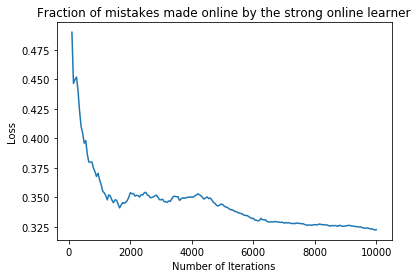

In [22]:
evaluate_onlineBBM(N=5, T=10000, architecture=2)

## Adaboost.OL

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.374
Fraction of mistakes by time 2000 0.358
Fraction of mistakes by time 3000 0.35633333333333334
Fraction of mistakes by time 4000 0.35375
Fraction of mistakes by time 5000 0.3462
Fraction of mistakes after 5000 iterations: 0.3462
Edges of weak learners:
 [0.15   0.1384 0.1264 0.119  0.1156]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 54 %
Accuracy of weak learner 1 on the 2000 test images: 75 %
Accuracy of weak learner 2 on the 2000 test images: 59 %
Accuracy of weak learner 3 on the 2000 test images: 72 %
Accuracy of weak learner 4 on the 2000 test images: 57 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 73 %


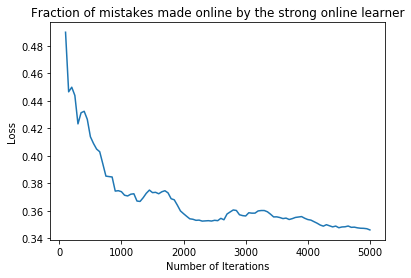

In [23]:
evaluate_adaboostOL(N=5, T=5000, architecture=2)

## Run Experiments

In [21]:
def run_experiment(T=10000, N=10, net=0, model="bbm"):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, net)
    
# ignore net input

In [ ]:
run_experiment(T=20000, N=5, net=0, model="adaboost")

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf